In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lab2_proto import *
from prondict import prondict
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 3) Data and Model set

In [2]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']
#phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

In [3]:
list(sorted(phoneHMMs.keys()))

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [4]:
phoneHMMs['ah'].keys()

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

# 4) Concatenating HMMs

In [5]:
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

print(isolated['o'])

['sil', 'ow', 'sil']


In [6]:
wordHMMs = {}
wordHMMs['o'] = concatHMMs(phoneHMMs, isolated['o'])
#wordHMMs['o']

In [7]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

In [8]:
means = wordHMMs['o']['means']
covars = wordHMMs['o']['covars']
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], means, covars)
#(example['obsloglik'] - log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars']))[:4]

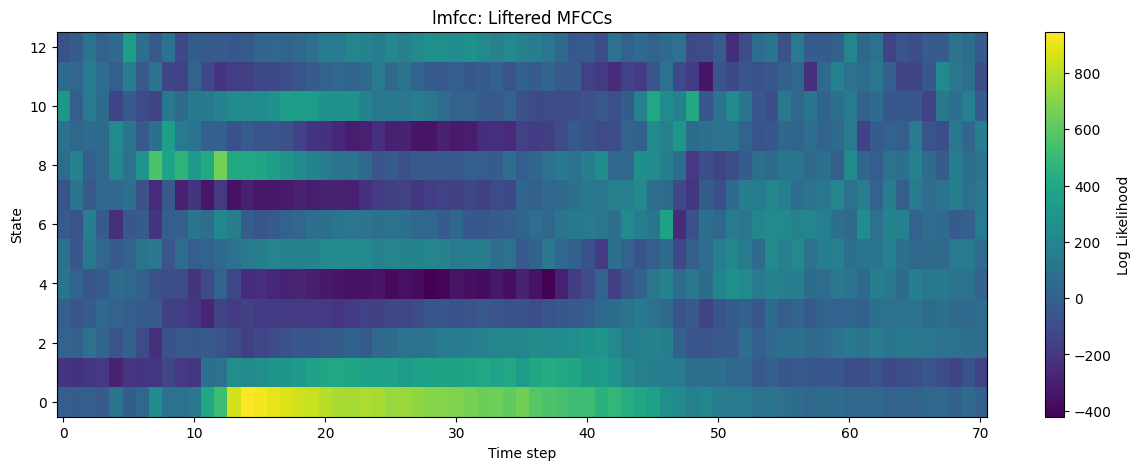

In [9]:
plt.figure(figsize=(15, 5))
plt.imshow(example['lmfcc'].T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('lmfcc: Liftered MFCCs')
plt.show()

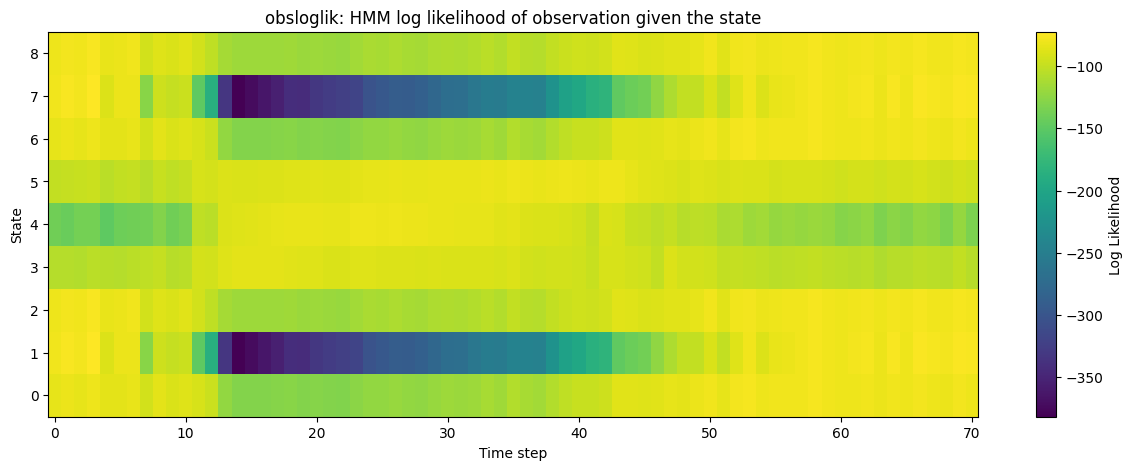

In [10]:
plt.figure(figsize=(15, 5))
plt.imshow(obsloglik.T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('obsloglik: HMM log likelihood of observation given the state')
plt.show()

* What can you say about the figure? \
answer

* Which Gaussian components give the high likelihood in which time steps? Why? Remember that each utterance starts and ends with silence. \
answer

In [11]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']

# 5.2) Forward algorithm - Evaluate an HMM

The Forward algorithm is a dynamic programming approach to calculate the likelihood P(X|theta) of an observation sequence X = (X1, X2, ..., XT) given the HMM theta. The algorithm proceeds sequentially over the sequence, computing forward probabilities that represent the joint probability of observing a particular subsequence of data and being in a specific state of the model at each time step.

In [12]:
logalpha = forward(example['obsloglik'], np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))
#logalpha - example['logalpha']

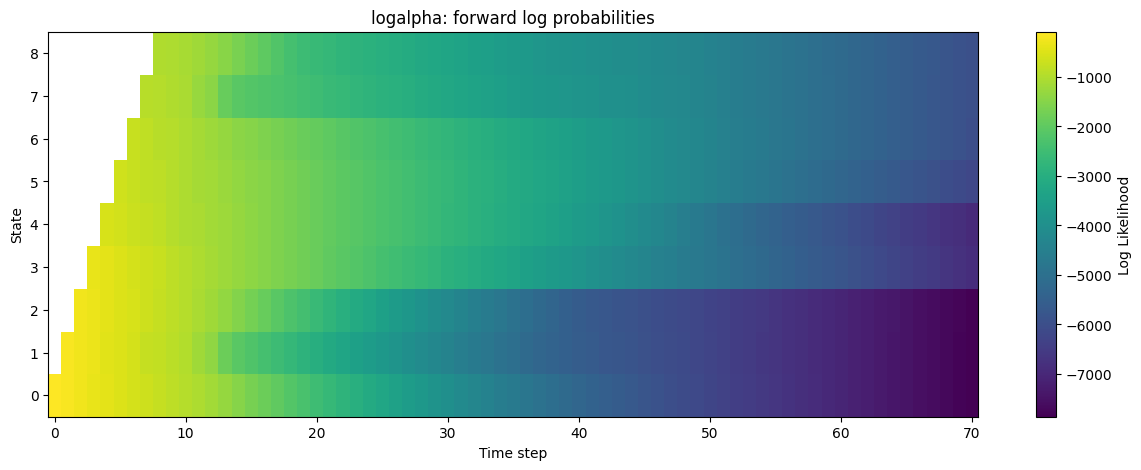

In [13]:
plt.figure(figsize=(15, 5))
plt.imshow(logalpha.T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('logalpha: forward log probabilities')
plt.show()

In [14]:
word_hmms = {}
for digit in prondict.keys():
    word_hmms[digit] = concatHMMs(phoneHMMs, ['sil'] + prondict[digit] + ['sil'])

data = np.load('lab2_data.npz', allow_pickle=True)['data']
#data.shape # (44,)

In [15]:
optimal_hmm = {}
successful_pred = 0
for i, df in enumerate(data):
    max_log_likelihood = None
    for digit in word_hmms.keys():
        means, covars = word_hmms[digit]['means'], word_hmms[digit]['covars']
        startprob, transmat = word_hmms[digit]['startprob'], word_hmms[digit]['transmat']

        obsloglik = log_multivariate_normal_density_diag(df['lmfcc'], means, covars)
        logalpha = forward(obsloglik, np.log(startprob), np.log(transmat))
        loglik = logsumexp(logalpha[-1])

        if max_log_likelihood is None or max_log_likelihood < loglik:
            optimal_hmm[i] = digit
            max_log_likelihood = loglik
    if df['digit'] == optimal_hmm[i]:
        successful_pred += 1

acc = np.round(successful_pred / len(data) * 100, 1)
print("Accuracy forward algorithm: " + str(acc))

Accuracy forward algorithm: 97.7


* Do you see any mistakes if you take the maximum likelihood model as winner? \
answer

* Compare the results obtained from the models trained on a single speaker or all the training speakers. \
answer

# 5.3) Viterbi algorithm - Decode an HMM

The Viterbi algorithm is a dynamic programming algorithm for finding the most probable sequence of hidden states—called the Viterbi path—that results in a sequence of observed events, especially in the context of Markov information sources and hidden Markov models (HMM).

The accuracy of the predictions has been: 100.0


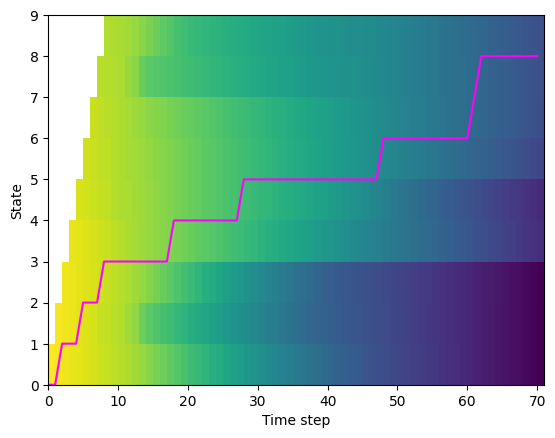

In [16]:
optimal_hmm = {}
successful_pred = 0
for i, df in enumerate(data):
    max_log_likelihood = None
    for digit in word_hmms.keys():
        means, covars = word_hmms[digit]['means'], word_hmms[digit]['covars']
        startprob, transmat = word_hmms[digit]['startprob'], word_hmms[digit]['transmat']

        obsloglik = log_multivariate_normal_density_diag(df['lmfcc'], means, covars)
        viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(startprob), np.log(transmat))
        if max_log_likelihood is None or max_log_likelihood < viterbi_loglik:
            optimal_hmm[i] = digit
            max_log_likelihood = viterbi_loglik
    if df['digit'] == optimal_hmm[i]:
        successful_pred += 1

acc = np.round(successful_pred / len(data) * 100, 1)
print("The accuracy of the predictions has been: " + str(acc))

startprob_o = word_hmms['o']['startprob']
transmat_o = word_hmms['o']['transmat']

logalpha = forward(example['obsloglik'], np.log(startprob_o), np.log(transmat_o))
vloglik, viterbi_path = viterbi(example['obsloglik'], np.log(startprob_o), np.log(transmat_o))

plt.pcolormesh(logalpha.T)
plt.plot(viterbi_path.T, color="magenta")
plt.xlabel('Time step')
plt.ylabel('State')
plt.show()

* Can you explain the reason why the path looks this way? \
ans

* How many mistakes can you count if you take as winner the model with the maximum viterbi score? \
answer

* Are these the same mistakes obtained in previous section? \
ans

* Can you say something about the complexity of the viterbi scoring compared to the forward scoring (for example by measuring the CPU usage?) \
ans

# 5.4) Backward Algorithm

The backward algorithm in Hidden Markov Models (HMMs) is a dynamic programming algorithm used to calculate the probability of the future data given a current state. This probability is called the backward probability. The backward algorithm is closely related to the forward algorithm, but instead of starting at the beginning of the observed sequence and moving forwards, it starts at the end and moves backwards.

In [17]:
# using example
logbeta = backward(example['obsloglik'], np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))
logbeta - example['logbeta']

array([[-1.43241049e-02,  3.26782594e-01,  3.99795393e-01,
         4.13029080e-01,  9.53554095e-01,  6.03007243e-01,
         2.89606005e+00,  1.13045494e+00,  1.20346774e+00],
       [-3.97518855e-02,  2.99397870e-01,  3.82602997e-01,
         4.05990986e-01,  9.48474994e-01,  5.97928142e-01,
         2.84337775e+00,  1.10307021e+00,  1.18627534e+00],
       [-4.75696169e-02,  2.87944165e-01,  3.65410601e-01,
         3.98952892e-01,  9.43395892e-01,  5.92849040e-01,
         2.79069545e+00,  1.09161651e+00,  1.16908294e+00],
       [-2.92751219e-02,  2.80629570e-01,  3.48218205e-01,
         3.91914798e-01,  9.38316790e-01,  5.87769939e-01,
         2.73801314e+00,  1.08430191e+00,  1.15189055e+00],
       [-8.19574190e-02,  2.58128586e-01,  3.31025809e-01,
         3.84876705e-01,  9.33237689e-01,  5.82690837e-01,
         2.68533084e+00,  1.06180079e+00,  1.13469815e+00],
       [-6.44996365e-02,  2.46244810e-01,  3.13833412e-01,
         3.77838611e-01,  9.28158587e-01,  5.776117

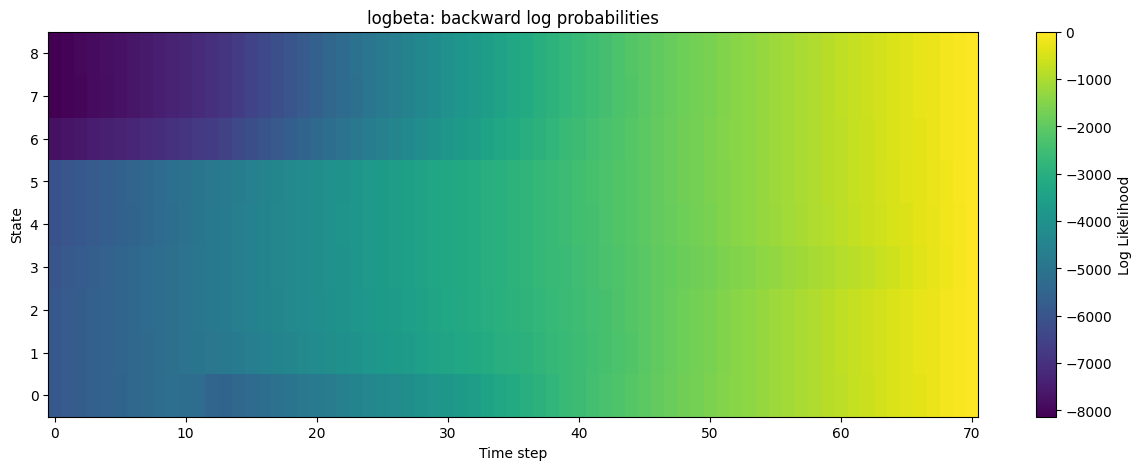

In [19]:
plt.figure(figsize=(15, 5))
plt.imshow(logbeta.T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('logbeta: backward log probabilities')
plt.show()

# 6) HMM Retraining (emission probability distriubtions)